In [1]:
# %load std_libraries.py
#to keep my scripts consistent, I am adding this to the top of all scripts with %load std_libraries.py
import sys
#Indicate operating environment and import core modules
location_input = input("what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = other")
location_dict = {'a': "C:\\Users\\BMH_work\\github\\expression_broad_data", 'b': "/home/heineike/github/expression_broad_data",
                 'c': "C:\\Users\\Ben\\Documents\\GitHub\\expression_broad_data", 'd':'you need to add your location to the location_dict'}
base_dir = location_dict[location_input]
print("base directory is " + base_dir)

if sys.path[-1] != base_dir:
    sys.path.append(base_dir)
    print("Added " + base_dir + " to path: " )
    print(sys.path)

import os

print("I am about to import a library")
from core import expression_plots 
from core import io_library 
%load_ext autoreload
%autoreload 2
# %matplotlib 
# plt.ioff()
#%matplotlib inline
%matplotlib notebook
data_processing_dir = base_dir + os.sep + os.path.normpath("expression_data") + os.sep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.colormap as cm
#from matplotlib_venn import venn2
#for my windows10 laptop I had to install this package using pip rather than anaconda.  
import seaborn as sns; sns.set(style="ticks", color_codes=True)
#from sklearn import linear_model
import pickle
#import subprocess
#import networkx as nx
import scipy.stats as stats
import scipy.spatial.distance as spd
import statsmodels.api as sm
#import statsmodels.graphics.gofplots as stats_graph
import scipy.cluster.hierarchy as sch

# from Bio import SeqIO
# from Bio import SeqFeature as sf
# from Bio.Alphabet import generic_dna
# from Bio.Seq import Seq

# import re

from collections import Counter
# import scipy.stats as stats
# from itertools import chain
#from itertools import product
#this only works if you are online
online_input = input("are you online? Yes/No ")
if online_input == "Yes": 
    import plotly.plotly as py
    import plotly.graph_objs as pygo
    import plotly.tools as pytools
    py.sign_in('heineike02_student','9dMTMZgJMgUP0YX0P5mQ')
    #py.sign_in('heineike02', 'APPjKrtARaN2ZgUYIkqr')
    
# for phylogenetic trees: 
# from ete3 import Tree
#ete3 is not officially supported on windows, and so must be loaded via pip: 
# pip install -U https://github.com/etetoolkit/ete/archive/qt5.zip
# ref: https://groups.google.com/forum/#!topic/etetoolkit/6NblSBPij4o

#for scraping internet data (e.g. ncbi)
#import requests
#from lxml import etree    #parses xml output

spec_lookup = {'Klac' : 'Kluyveromyces lactis', 'Scer': 'Saccharomyces cerevisiae', 
 'Cgla' : 'Candida glabrata' , 'Ncas': 'Naumovozyma castellii', 
 'Sbay' : 'Saccharomyces bayanus', 'Smik': 'Saccharomyces mikatae',
 'Lwal' : 'Lachancea waltii', 'Spar' : 'Saccharomyces paradoxus', 
 'Lklu' : 'Lachancea kluyverii', 'Dhan': 'Debaryomyces hansenii', 
 'Calb' : 'Candida albicans', 'Ylip': 'Yarrowia lipolytica'}

what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = otherb
base directory is /home/heineike/github/expression_broad_data
Added /home/heineike/github/expression_broad_data to path: 
['', '/home/lab/envs/seqanalysis/lib/python35.zip', '/home/lab/envs/seqanalysis/lib/python3.5', '/home/lab/envs/seqanalysis/lib/python3.5/plat-linux', '/home/lab/envs/seqanalysis/lib/python3.5/lib-dynload', '/home/lab/envs/seqanalysis/lib/python3.5/site-packages', '/home/lab/envs/seqanalysis/lib/python3.5/site-packages/argh-0.26.1-py3.5.egg', '/home/lab/envs/seqanalysis/lib/python3.5/site-packages/glob2-0.4.1-py3.5.egg', '/home/lab/envs/seqanalysis/lib/python3.5/site-packages/mmtf_python-1.0.2-py3.5.egg', '/home/lab/envs/seqanalysis/lib/python3.5/site-packages/IPython/extensions', '/home/heineike/.ipython', '/home/heineike/github/expression_broad_data']
I am about to import a library
I am importing io_library
what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's

In [2]:
#Load GOI ohnolog data

fname = data_processing_dir + os.sep + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017/gois_20181205.pkl')

with open(fname, 'rb') as file:
    [ohnologs_goi,ohnologs_expression_sorted,goi_criteria] = pickle.load(file)

#Load KL ortholog data
kl_orthologs = pd.read_pickle(data_processing_dir + "ortholog_files_YGOB/kl_orthologs.pkl")

#load average rlog data
rlog_data_mean_var = {}
for spec in ['SC', 'KL']:
    rlog_data_mean_var[spec] = pd.read_csv(os.path.normpath(data_processing_dir + '\\kl_sc_PKA_as_m24_r1g1_20181017\\20181017_rlog_mean_' + spec + '.csv' ),index_col=0)

#Rename KL rlog data columns: 
new_kl_columns = [column + '_kl' for column in rlog_data_mean_var['KL'].columns]
rlog_data_mean_var['KL'].columns = new_kl_columns

#Merge k.lac rlog data with ohnolog_gois
ohnologs_goi_klorth = ohnologs_goi.merge(kl_orthologs, how='left', left_on='sc_genename_low',right_on='sc_genename')
ohnologs_goi_rlog = ohnologs_goi_klorth.merge(rlog_data_mean_var['KL'], how = 'left', left_on='kl_genename', right_index = True)
    

FileNotFoundError: File b'/home/heineike/github/expression_broad_data/expression_data/\\kl_sc_PKA_as_m24_r1g1_20181017\\20181017_rlog_mean_SC.csv' does not exist

In [129]:
# # Used parse_raw_exp to make expression data for all species from Tsankov et al 2010 
# for spec in spec_lookup.keys():
#     fname = data_processing_dir + os.sep + os.path.normpath('regev_data/raw_exp/' + spec + '_raw_exp.csv')
#     raw_exp, platform_dict = io_library.parse_raw_exp(spec, fname)



In [3]:
#S.Cer

spec = 'Scer'

#Load expression data
fname = data_processing_dir + os.sep + os.path.normpath('regev_data/raw_exp/' + spec + '_raw_exp.csv')
raw_exp_tsankov = pd.read_csv(fname, index_col='orf_name')

# #Take mean of all data that has more than one spot per orf
# #Also only select out column of mean expression across replicates
# grouped = raw_exp_tsankov.groupby('orf_name')
# raw_exp_tsankov_mean = grouped.mean().loc[:,'Mean']

for level in ['low','high']: 
    raw_exp_tsankov_mean_level = raw_exp_tsankov['med_qnorm'].reindex(list(ohnologs_goi_rlog['sc_genename_' + level]))
    ohnologs_goi_rlog[spec + '_raw_exp_tsankov_' + level] = list(raw_exp_tsankov_mean_level)

    
#K.Lac
spec = 'Klac'

fname = data_processing_dir + os.sep + os.path.normpath('regev_data/raw_exp/' + spec + '_raw_exp.csv')
raw_exp_tsankov = pd.read_csv(fname, index_col = 'orf_name')

#Take mean of all data that has more than one spot per orf
#Also only select out column of mean expression across replicates

#add data to dataframe
raw_exp_tsankov_mean_goi = raw_exp_tsankov['med_qnorm'].reindex(list(ohnologs_goi_rlog['kl_genename']))
ohnologs_goi_rlog[spec + '_raw_exp_tsankov_YGOB'] = list(raw_exp_tsankov_mean_goi)


In [132]:
colors = {'low': 'blue', 'high': 'red'}

hover_text = []
#might be nice to add kl LFC to this
for ind, row in ohnologs_goi_rlog.iterrows():
    hover_text.append(('Low Paralog: {SC_common_name_low}<br>  LFC: {LFC_low:.2f}<br>  -log10(pval): {pval_low:.2f}<br>' +
                       'High Paralog: {SC_common_name_high}<br>  LFC: {LFC_high:.2f}<br>  -log10(pval): {pval_high:.2f}<br>' +
                       'KL genename: {kl_genename}').format(
                        SC_common_name_low = row['SC_common_name_low'],
                        LFC_low = row['log2FoldChange_low'],
                        pval_low = -np.log10(row['pvalue_low']),
                        SC_common_name_high = row['SC_common_name_high'],
                        LFC_high = row['log2FoldChange_high'],
                        pval_high = -np.log10(row['pvalue_high']),
                        kl_genename = row['kl_genename'])
                      )
data = []
corr_coef = {}
for level in ['low','high']:
    xdata = ohnologs_goi_rlog['AS_WT_cont_mean_' + level]
    ydata = ohnologs_goi_rlog['Scer_raw_exp_tsankov_' + level]
    
    trace = pygo.Scatter(
                x = xdata, 
                y = ydata,
                text = hover_text,
                mode = 'markers',
                marker = {'opacity': 0.9,  
                          'color': colors[level],
                          'size': 10}, 
                name = 'SCer ' + level + ' induction paralogs'
            )

    data.append(trace)
    
    #Remove NA and get correlation coefficient
    xy_data = pd.DataFrame()
    xy_data['xdata']=xdata
    xy_data['ydata']=ydata
    xy_data_nanrm = xy_data[((~xy_data['xdata'].isna()) & (~xy_data['ydata'].isna()) )]
    corr_coef['Scer_'+level] = np.corrcoef(xy_data_nanrm.T)[0][1]
    
    
    
xdata = ohnologs_goi_rlog['AS_WT_cont_mean_kl']
ydata = ohnologs_goi_rlog['Klac_raw_exp_tsankov_YGOB']
trace = pygo.Scatter(
                x = xdata , 
                y = ydata ,
                text = hover_text,
                mode = 'markers',
                marker = {'opacity': 0.9,  
                          'color': 'green',
                          'size': 10}, 
                name = 'KLac orthologs'
            )

data.append(trace)

#Remove NA and get correlation coefficient
xy_data = pd.DataFrame()
xy_data['xdata']=xdata
xy_data['ydata']=ydata
xy_data_nanrm = xy_data[((~xy_data['xdata'].isna()) & (~xy_data['ydata'].isna()) )]
corr_coef['Klac'] = np.corrcoef(xy_data_nanrm.T)[0][1]

annotation_text = 'Correlation Coeff <br>'
for gene_set, corr in corr_coef.items():
    annotation_text = annotation_text + '{} : {:.2f} <br>'.format(gene_set,corr)

layout = pygo.Layout(
    xaxis= {
        #"range":[-20, 20],
        "title": 'rlog'
    },
    yaxis= {
        #"range":[-10, 10],
        "title": 'LFC mRNA / gDNA'
    },
    annotations=[
        dict(
            x=13,
            y=-5,
            xref='x',
            yref='y',
            text=annotation_text,
            showarrow=False
        )
    ]
)


fig = pygo.Figure(data=data, layout = layout)
py.iplot(fig, filename= 'rlog_vs_tsankov')

Supp Figure [rlog vs tsankov] The raw expression data from Tsankov et al [ref ??] is correlated with our rlog data.  rlog data for our differentially expressed paralogs in PKA(AS) cells grown for 45 min with DMSO are shown on the x axis.  Data from microarrays in which mRNA in cells in exponential growth phase in ??? media were competitively hybridized against genomic DNA.  NA values are removed.  

{'whiskers': [<matplotlib.lines.Line2D at 0x268bddddc18>,
 'caps': [<matplotlib.lines.Line2D at 0x268bddc93c8>,
 'boxes': [<matplotlib.lines.Line2D at 0x268bdddd978>,
 'medians': [<matplotlib.lines.Line2D at 0x268bddc9c18>,
 'fliers': [<matplotlib.lines.Line2D at 0x268bddc9cf8>,
 'means': []}

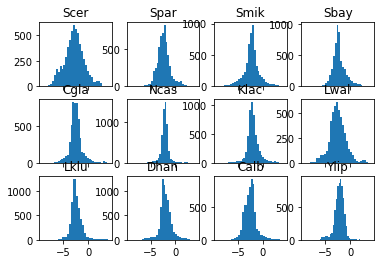

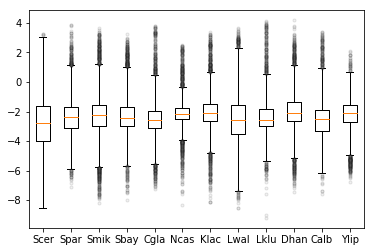

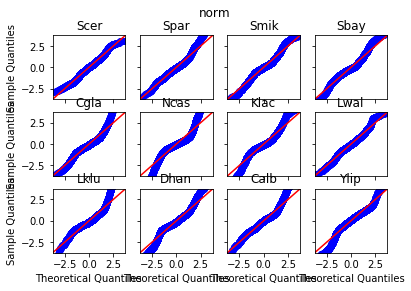

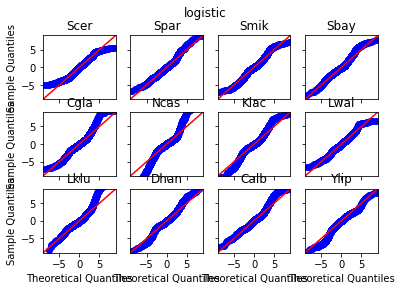

In [7]:
#Load all the data and check the distribution

fig_hist, axarr_hist = plt.subplots(3,4, sharex = True)

fig_boxplot, ax_boxplot = plt.subplots()

figs_qq = {}
axarr_qq = {}
dist_dict = dist_dict = {'norm': stats.norm , 'logistic': stats.logistic}

for dist_name in dist_dict.keys():
    figs_qq[dist_name], axarr_qq[dist_name] = plt.subplots(3,4, sharex = True, sharey = True)
    figs_qq[dist_name].suptitle(dist_name)
                                                           
spec_order_post_WGH = ['Scer','Spar','Smik','Sbay', 'Cgla', 'Ncas']
spec_order_pre_WGH = ['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip']

raw_exp_tsankov_all = {}

boxplot_data = []

for jj, spec in enumerate(spec_order_post_WGH+spec_order_pre_WGH) : 
    #Load expression data
    fname = data_processing_dir + os.sep + os.path.normpath('regev_data/raw_exp/' + spec + '_raw_exp.csv')
    raw_exp_tsankov = pd.read_csv(fname, index_col = 'orf_name')
    raw_exp_tsankov_all[spec] = raw_exp_tsankov['med_qnorm']
    boxplot_data.append(raw_exp_tsankov_all[spec])
    ax_hist = axarr_hist.flatten()[jj]
    ax_hist.hist(raw_exp_tsankov_all[spec], bins=30)
    ax_hist.set_title(spec)
    
    
    for dist_name, dist in dist_dict.items(): 
        ax_qq = axarr_qq[dist_name].flatten()[jj]
        sm.qqplot(raw_exp_tsankov_all[spec], dist = dist, fit = True, line = '45', ax = ax_qq )
        ax_qq.set_title(spec)
    
        ax_qq.set_ylabel('')
        ax_qq.set_xlabel('')
        if jj in [0,4,8]:
            ax_qq.set_ylabel('Sample Quantiles')
        if jj in [8,9,10,11]: 
            ax_qq.set_xlabel('Theoretical Quantiles')

flierprops = dict(marker='o', markerfacecolor='grey', markersize=3,
                  linestyle='none', alpha = 0.1)
ax_boxplot.boxplot(boxplot_data, whis=2.0, labels = spec_order_post_WGH+spec_order_pre_WGH, flierprops=flierprops)    



The distributions of expression between the different species seems different.  Some are more normal than others (SCer, LWal)  and some look more logistic than others  (SPar, SBay, Dhan, YLip).  As a rough comparison, I will just assume a standard normal distribution and scale by mean and variance.  In particular S.Cer seems to have a much wider variance - I am imagining that the microarray for S.Cer had a lot more probes for lower expressing genes - and maybe the probes for the other species were constrained to those that were highest expressing?   

{'whiskers': [<matplotlib.lines.Line2D at 0x268bdf0e748>,
 'caps': [<matplotlib.lines.Line2D at 0x268bf98b470>,
 'boxes': [<matplotlib.lines.Line2D at 0x268bdf0e470>,
 'medians': [<matplotlib.lines.Line2D at 0x268bf98b550>,
 'fliers': [<matplotlib.lines.Line2D at 0x268bf97b748>,
 'means': []}

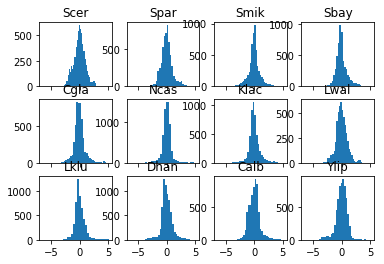

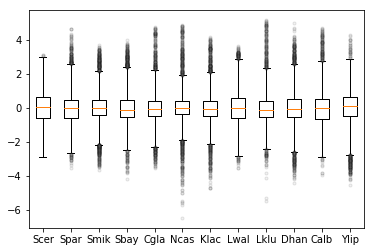

In [8]:
fig_hist, axarr_hist = plt.subplots(3,4, sharex = True)

fig_boxplot, ax_boxplot = plt.subplots()


raw_exp_tsankov_all_norm = {}

boxplot_data = []
for jj, spec in enumerate(spec_order_post_WGH+spec_order_pre_WGH) : 
    std = raw_exp_tsankov_all[spec].std()
    mu = raw_exp_tsankov_all[spec].mean()
    raw_exp_tsankov_all_norm[spec] = (raw_exp_tsankov_all[spec]-mu)/std

    boxplot_data.append(raw_exp_tsankov_all_norm[spec])
    ax_hist = axarr_hist.flatten()[jj]
    ax_hist.hist(raw_exp_tsankov_all_norm[spec], bins=30)
    ax_hist.set_title(spec)

flierprops = dict(marker='o', markerfacecolor='grey', markersize=3,
                  linestyle='none', alpha = 0.1)
ax_boxplot.boxplot(boxplot_data, whis=2.0, labels = spec_order_post_WGH+spec_order_pre_WGH, flierprops=flierprops)    


In [9]:
#Post WGH data
spec_order_post_WGH = ['Spar','Smik','Sbay', 'Cgla', 'Ncas']
#Smik missing mapping from ygob names to Regev lab orthogroups.  C.Gla mapping for Sec14 seems better with orthogroups than YGOB
#Going to start with orthogroup mapping from Regev lab for all of them. 
#K.Lac had a major discrepancy with annotation in regev lab data.   

#Species that have a column on the pillars file: 'Klac, Lwal, Lklu, Scer, Smik, Cgla, Ncas'
#Should also do one with Pillars orthologs


for spec in spec_order_post_WGH: 
    #load ortholog mapping

    orth_dir = data_processing_dir + 'ortholog_files' + os.sep 
    sc_spec_orth_lookup = io_library.read_orth_lookup_table('Scer', spec, orth_dir)

    #Load expression data
    raw_exp_tsankov_norm = raw_exp_tsankov_all_norm[spec]

    for level in ['low','high']: 
        raw_exp_tsankov_norm_level = []
        for gene in ohnologs_goi_rlog['sc_genename_' + level ]: 
            try: 
                if sc_spec_orth_lookup[gene][0]=='NONE':
                    raw_exp_tsankov_norm_level.append('NONE_in_orthogroups')
                else: 
                    raw_exp_list = [raw_exp_tsankov_norm[spec_gene] for spec_gene in sc_spec_orth_lookup[gene]]
                    raw_exp_tsankov_norm_level.append(raw_exp_list) 
            except KeyError:
                print(gene + ' has no ortholog in ' + spec)
                raw_exp_tsankov_norm_level.append('NONE_not_in_orthogroups')
        ohnologs_goi_rlog[spec + '_raw_exp_tsankov_' + level] = list(raw_exp_tsankov_norm_level)



spec_order_pre_WGH = ['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip']

for spec in spec_order_pre_WGH: 

    #load ortholog mapping

    orth_dir = data_processing_dir + 'ortholog_files' + os.sep 
    sc_spec_orth_lookup = io_library.read_orth_lookup_table('Scer', spec, orth_dir)

    raw_exp_tsankov_norm = raw_exp_tsankov_all_norm[spec]

    raw_exp_tsankov_norm_spec = []
    for row in ohnologs_goi_rlog.loc[:,['sc_genename_low','sc_genename_high']].iterrows():
        gene_low = row[1]['sc_genename_low']
        gene_high = row[1]['sc_genename_high']

        try:         
            if sc_spec_orth_lookup[gene_low] == sc_spec_orth_lookup[gene_high]: 
                gene_to_test = gene_low
                if sc_spec_orth_lookup[gene_to_test][0]=='NONE':
                    raw_exp_tsankov_norm_spec.append('NONE_in_orthogroups')
                else: 
                    raw_exp_list = []
                    for spec_gene in sc_spec_orth_lookup[gene_to_test]: 
                        try: 
                            raw_exp_list.append(raw_exp_tsankov_norm[spec_gene])
                        except KeyError: 
                            print(spec_gene + ' not in tsankov raw_exp dataset for ' + spec)
                            raw_exp_list.append('NONE_not_in_tsankov_microarray')
                    raw_exp_tsankov_norm_spec.append(raw_exp_list) 
            else: 
                print('high and low paralogs do not match ' + gene_low + ' and ' + gene_high )
        except KeyError: 
            print('either ' + gene_low + ' or ' + gene_high + ' has no ortholog in ' + spec)     
            gene_to_test = 'NONE'
            if gene_low in sc_spec_orth_lookup.keys():
                gene_to_test = gene_low
            elif gene_high in sc_spec_orth_lookup.keys():
                gene_to_test = gene_high

            if gene_to_test != 'NONE':
                print(gene_to_test + ' did have an ortholog in ' + spec)
                if sc_spec_orth_lookup[gene_to_test][0]=='NONE':
                    raw_exp_tsankov_norm_spec.append('NONE_in_orthogroups')
                else: 
                    raw_exp_list = []
                    for spec_gene in sc_spec_orth_lookup[gene_to_test]: 
                        try: 
                            raw_exp_list.append(raw_exp_tsankov_norm[spec_gene])
                        except KeyError: 
                            print(spec_gene + ' not in tsankov raw_exp dataset for ' + spec)
                            raw_exp_list.append('NONE_not_in_tsankov_microarray')
                    raw_exp_tsankov_norm_spec.append(raw_exp_list) 
            else:
                print('neither ' + gene_low + ' nor ' + gene_high + ' has an ortholog in ' + spec)
                raw_exp_tsankov_norm_spec.append('NONE_not_in_orthogroups')
    
    print(len(raw_exp_tsankov_norm_spec))
    ohnologs_goi_rlog[spec + '_raw_exp_tsankov'] = list(raw_exp_tsankov_norm_spec)
    



YBR056W-A has no ortholog in Spar
YBR056W-A has no ortholog in Smik
YBR056W-A has no ortholog in Sbay
YNL052W has no ortholog in Cgla
YBR056W-A has no ortholog in Cgla
YHR092C has no ortholog in Cgla
YIL111W has no ortholog in Cgla
YDR342C has no ortholog in Cgla
YHR096C has no ortholog in Cgla
YDR524C-B has no ortholog in Ncas
YNL052W has no ortholog in Ncas
YBR056W-A has no ortholog in Ncas
YGR131W has no ortholog in Ncas
YLR043C has no ortholog in Ncas
YHR108W has no ortholog in Ncas
YLR293C has no ortholog in Ncas
YLR297W has no ortholog in Ncas
YOR375C has no ortholog in Ncas
YFL048C has no ortholog in Ncas
YCL048W-A has no ortholog in Ncas
YNR001C has no ortholog in Ncas
YNL093W has no ortholog in Ncas
YNL055C has no ortholog in Ncas
YIL113W has no ortholog in Ncas
YLR031W has no ortholog in Ncas
YKL091C has no ortholog in Ncas
YDL021W has no ortholog in Ncas
YDR034W-B has no ortholog in Ncas
YLR346C has no ortholog in Ncas
YGR256W has no ortholog in Ncas
YJL045W has no ortholog 

In [16]:
columns_to_view = ['SC_common_name_high', 'SC_common_name_low','Scer_raw_exp_tsankov_low',
       'Scer_raw_exp_tsankov_high', 'Klac_raw_exp_tsankov',
       'Spar_raw_exp_tsankov_low', 'Spar_raw_exp_tsankov_high',
       'Smik_raw_exp_tsankov_low', 'Smik_raw_exp_tsankov_high',
       'Sbay_raw_exp_tsankov_low', 'Sbay_raw_exp_tsankov_high',
       'Cgla_raw_exp_tsankov_low', 'Cgla_raw_exp_tsankov_high',
       'Ncas_raw_exp_tsankov_low', 'Ncas_raw_exp_tsankov_high',
       'Klac_raw_exp_tsankov_YGOB', 'Lwal_raw_exp_tsankov',
       'Lklu_raw_exp_tsankov', 'Dhan_raw_exp_tsankov', 'Calb_raw_exp_tsankov',
       'Ylip_raw_exp_tsankov','AS_WT_cont_mean_high','AS_WT_cont_mean_low','AS_WT_cont_mean_kl']

In [17]:
ohnologs_goi_rlog.loc[ohnologs_goi_rlog['SC_common_name_high']=='CYC7',columns_to_view].T

,10
SC_common_name_high,CYC7
SC_common_name_low,CYC1
Scer_raw_exp_tsankov_low,0.691536
Scer_raw_exp_tsankov_high,-2.56251
Klac_raw_exp_tsankov,"[2.3090468270446145, 2.4377150586552707]"
Spar_raw_exp_tsankov_low,[1.4179710716538205]
Spar_raw_exp_tsankov_high,[0.04447451466777952]
Smik_raw_exp_tsankov_low,[1.7550471975190243]
Smik_raw_exp_tsankov_high,[-0.6818892939829854]
Sbay_raw_exp_tsankov_low,[-0.37271691073439367]


In [292]:
ohnologs_goi_rlog['SC_common_name_high']

0     YCL048W-A
1          ALP1
2          TPK1
3          PIR3
4         DAL80
5          PRY1
6         YSC84
7          CMK1
8          HEF3
9          CIT1
10         CYC7
11         PRM6
12         ADY3
13        YPT53
14         POR1
15         SDP1
16        COX5B
17         NDE2
18      YLR031W
19        ADE16
20         PGM2
21      YKL091C
22         STB2
23         RTC2
24         GPD1
25         GPM2
26      YDR018C
27    YDR034W-B
28         PST1
29         UBC5
        ...    
61         TOS8
62         USV1
63        HSP82
64    YNR034W-A
65         GDH3
66         PYK2
67        FUN19
68         FRT2
69         PSK1
70      YIR016W
71         RNR3
72         SNF3
73         SHC1
74         UBP9
75         AVT6
76        SCS22
77      YPR172W
78        EMP46
79      YFL042C
80         AFR1
81         CRF1
82         RTN2
83         VHS1
84         SSE2
85      YOR214C
86         ODC1
87         HER1
88         HES1
89        URA10
90         NGL3
Name: SC_common_name_hig

<IPython.core.display.Javascript object>


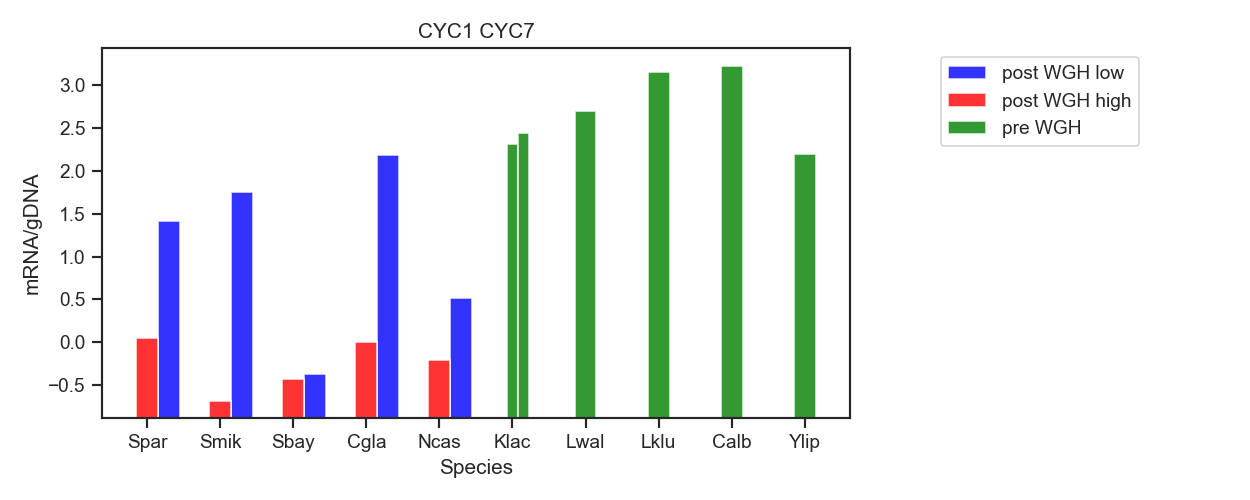

In [189]:
high_gene = 'CYC7'
row = ohnologs_goi_rlog[ohnologs_goi_rlog['SC_common_name_high']==high_gene]

fig, ax = plt.subplots(figsize = (10,4))
bar_width = 0.30
opacity = 0.8

spec_order_post_WGH = ['Spar','Smik','Sbay', 'Cgla', 'Ncas'] #['Scer','Spar','Smik','Sbay', 'Cgla', 'Ncas']
spec_order_pre_WGH = ['Klac','Lwal','Lklu', 'Calb', 'Ylip'] #['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip']


# data to plot

data = {}
index_post_WGH = {}
index_shift = {'high': 0.0, 'low': bar_width}
bar_width_post_WGH = {}
for level in ['high','low']: 
    index_post_WGH_level = []
    data_level = []
    bar_width_post_WGH_level = []
    for jj, spec in enumerate(spec_order_post_WGH): 
        raw_exp_values = row[spec + '_raw_exp_tsankov_' + level].values[0]
        
        if isinstance(raw_exp_values,str): #The value will be a string if there was no expression value
            index_post_WGH_level.append(jj)
            data_level.append(0)
            bar_width_post_WGH_level.append(bar_width)
        elif spec == 'Scer':  #Scer values are floats, not lists
            index_post_WGH_level.append(jj)
            data_level.append(raw_exp_values)
            bar_width_post_WGH_level.append(bar_width)
        else: 
            for kk, raw_exp_value in enumerate(raw_exp_values):
                index_post_WGH_level.append(jj + bar_width*kk/len(raw_exp_values))
                if isinstance(raw_exp_value,str):
                    raw_exp_value=0.0
                data_level.append(raw_exp_value)
                bar_width_post_WGH_level.append(bar_width/len(raw_exp_values))

    data[level] = data_level
    index_post_WGH[level] = np.array(index_post_WGH_level) + index_shift[level]
    bar_width_post_WGH[level] = bar_width_post_WGH_level


index_shift = len(spec_order_post_WGH)
index_pre_WGH = []
data_pre_WGH = []
bar_width_pre_WGH = []
for jj, spec in enumerate(spec_order_pre_WGH): 
    raw_exp_values = row[spec + '_raw_exp_tsankov'].values[0]
    if isinstance(raw_exp_values,str): #The value will be a string if there was no expression value
        index_pre_WGH.append(jj)
        data_pre_WGH.append(0)
        bar_width_pre_WGH.append(bar_width)
    else: 
        for kk, raw_exp_value in enumerate(raw_exp_values):
            index_pre_WGH.append(jj + bar_width*kk/len(raw_exp_values))
            if isinstance(raw_exp_value,str):
                raw_exp_value= np.nan  #0.0
            data_pre_WGH.append(raw_exp_value)
            bar_width_pre_WGH.append(bar_width/len(raw_exp_values))

index_pre_WGH = np.array(index_pre_WGH) + index_shift

#Set bottom of bar to be the lowest number in all the data

bottom = min(data['low']+data['high']+data_pre_WGH)-0.2

rects_low = plt.bar(index_post_WGH['low'], np.array(data['low'])-bottom, bar_width_post_WGH['low'],
                 alpha=opacity,
                 color='blue',
                 label='post WGH low', 
                 bottom = bottom)
 
rects_high = plt.bar(index_post_WGH['high'], np.array(data['high'])-bottom, bar_width_post_WGH['high'],
                 alpha=opacity,
                 color='red',
                 label='post WGH high', 
                 bottom = bottom)

rects_pre_WGH = plt.bar(index_pre_WGH, np.array(data_pre_WGH)-bottom, bar_width_pre_WGH,
                 alpha=opacity,
                 color='green',
                 label='pre WGH', 
                 bottom = bottom)
 
plt.xlabel('Species')
plt.ylabel('mRNA/gDNA')
plt.title(row['SC_common_name_low'].values[0] + ' ' + row['SC_common_name_high'].values[0])
plt.xticks(np.arange(len(spec_order_post_WGH)+len(spec_order_pre_WGH)), spec_order_post_WGH + spec_order_pre_WGH)
plt.legend(bbox_to_anchor=(1.4,1.0))
 
plt.tight_layout()
plt.show()

In [190]:
#Go through each of my GOIs and make a vector.
#If there are no orthologs, set the value to np.Nan
#If there is an unexpected duplicate gene set the value to the mean expression between the two

spec_order_post_WGH = ['Scer','Spar','Smik','Sbay', 'Cgla', 'Ncas']
spec_order_pre_WGH = ['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip']

expression_data = {}

for row in ohnologs_goi_rlog.itertuples(): 
    high_gene_common_name = getattr(row, 'SC_common_name_high') 
    low_gene_common_name = getattr(row, 'SC_common_name_low')
    
    expression_data_row = []
    
    for level in ['low', 'high']: 
        for spec in spec_order_post_WGH:
            raw_exp_values = getattr(row, spec + '_raw_exp_tsankov_' + level)
            expression_data_row.append(raw_exp_values)
    
    for spec in spec_order_pre_WGH:
        raw_exp_values = getattr(row, spec + '_raw_exp_tsankov')
        expression_data_row.append(raw_exp_values)
        
    
    expression_data_row_clean = []
    for point in expression_data_row: 
        if isinstance(point, str): 
            expression_data_row_clean.append(np.nan)
        elif isinstance(point,list):   #data from most species is a list - in case there is more than one ortholog
            Nstr = sum([isinstance(item, str) for item in point])
            if Nstr > 0:  #if at least one item is a string
                if Nstr == len(point):   #none of the orthologs have data
                    expression_data_row_clean.append(np.nan)
                else: 
                    point_clean = [item for item in point if isinstance(item,float)]
                    expression_data_row_clean.append(np.mean(point_clean))
            else:  #the typical case where neither item is a string 
                expression_data_row_clean.append(np.mean(point))
        else:    #This will only be for S.Cer since the data for everything else is from a list.  
            expression_data_row_clean.append(point)
    
    expression_data[high_gene_common_name + '_' + low_gene_common_name] = expression_data_row_clean
    
    


columns = [spec + '_low' for spec in spec_order_post_WGH] + [spec + '_high' for spec in spec_order_post_WGH] + spec_order_pre_WGH
expression_data_df = pd.DataFrame.from_dict(expression_data, orient = 'index', columns = columns)



<IPython.core.display.Javascript object>


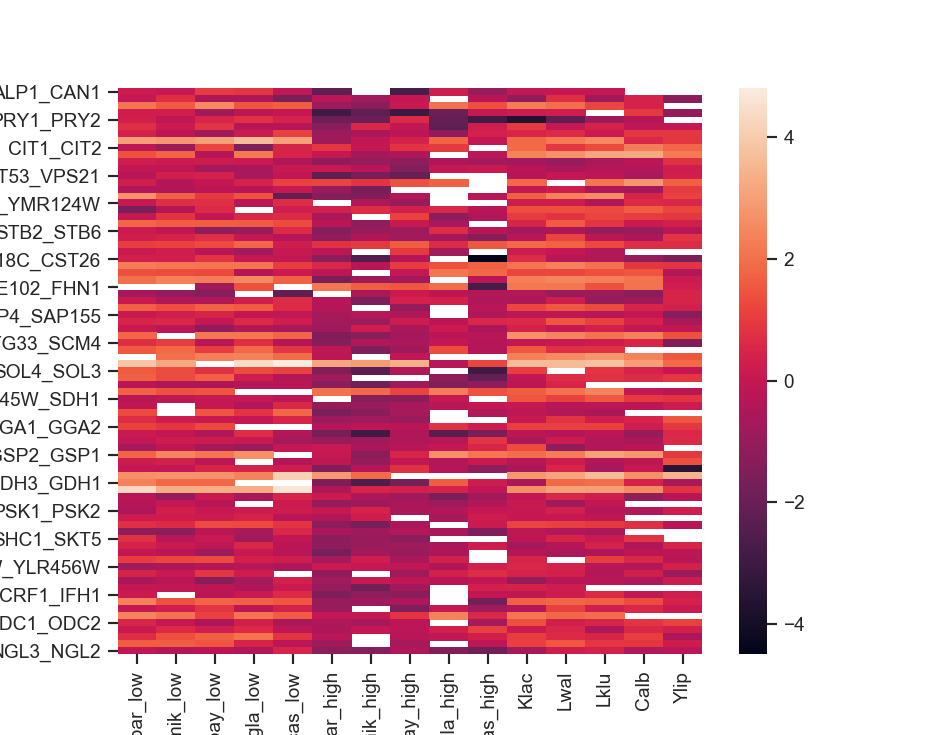

Dropped the following Paralog Pairs because there were more than 5 orthologs missing.
Index(['YCL048W-A_YDR524C-B', 'COX5B_COX5A', 'YDR034W-B_YBR056W-A',
       'YLR346C_YGR035C', 'YJR005C-A_YGR169C-A', 'HXT7_HXT4',
       'YOR186W_YLR297W', 'USV1_RGM1', 'YNR034W-A_YCR075W-A', 'YOR214C_SPO19'],
      dtype='object')


In [191]:
#heatmap prior to clustering, but after filtering wierd species and rows with many NANs

fig_hmap, ax_hmap = plt.subplots()

#Filter out S.Cer because its distribution is so different
#Filter out D.Han because there are so many NANs (probably an indexing problem in the ortholog/expression array set)
expression_data_df_spec_filter = expression_data_df.drop(columns = ['Scer_low', 'Scer_high', 'Dhan'])

#filter out a row if it has Ndrop or more missing orthologs
inds_to_drop = []
Ndrop = 5
for ind, row in enumerate(expression_data_df_spec_filter.values):
     if sum(np.isnan(row)) >= Ndrop:
        inds_to_drop.append(ind)
        
rows_to_drop = expression_data_df_spec_filter.index[inds_to_drop]
print('Dropped the following Paralog Pairs because there were more than ' + str(Ndrop) + ' orthologs missing.')
print(rows_to_drop)
expression_data_df_row_filter = expression_data_df_spec_filter.drop(index=rows_to_drop)


sns.heatmap(expression_data_df_row_filter)

<IPython.core.display.Javascript object>


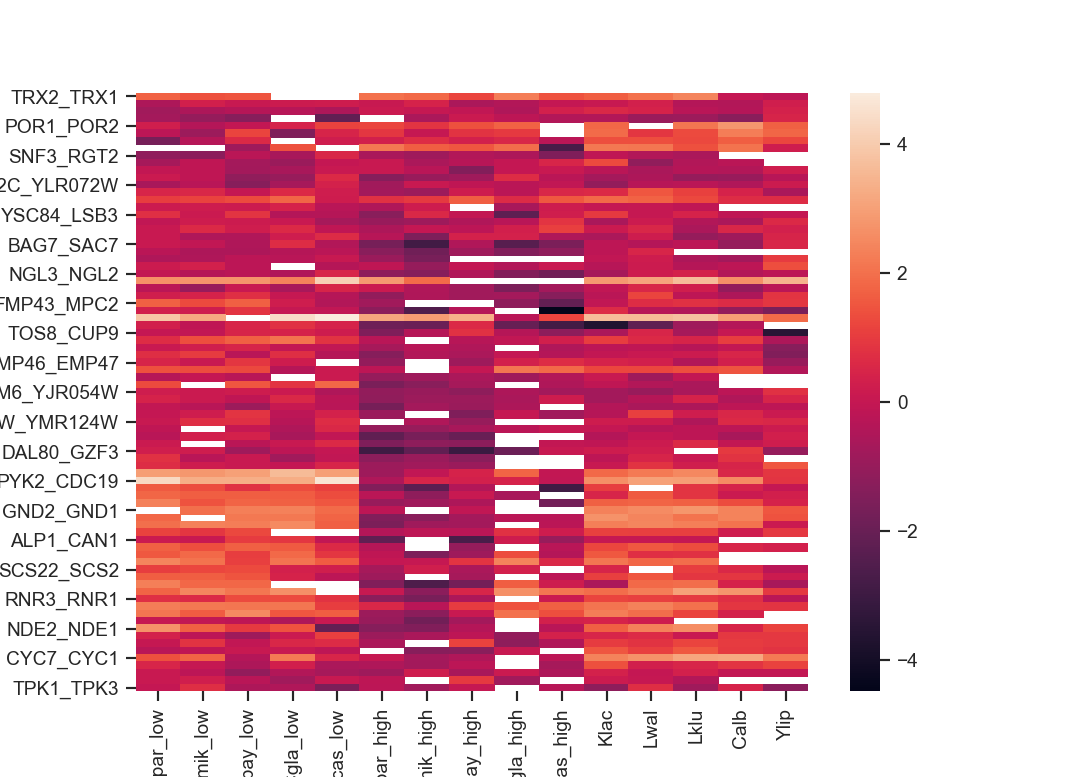

<IPython.core.display.Javascript object>


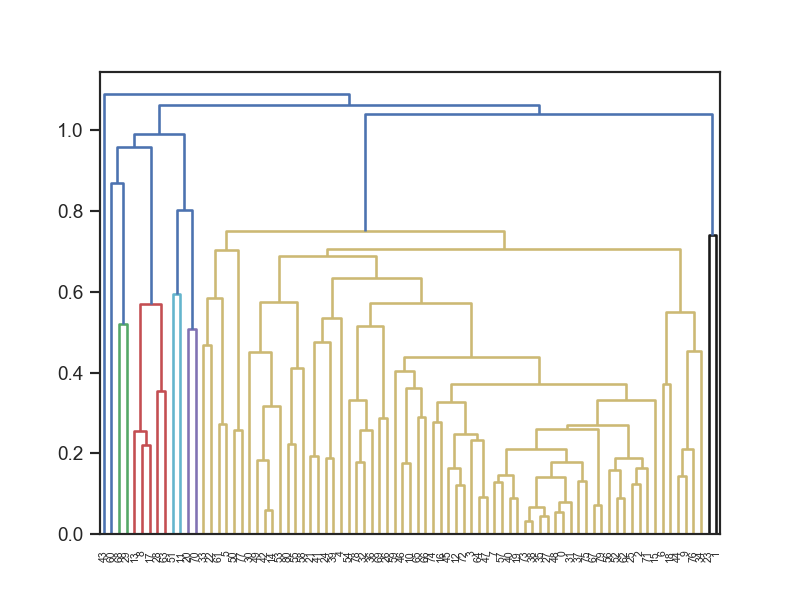

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [75.0, 75.0, 85.0, 85.0],
  [52.5, 52.5, 80.0, 80.0],
  [22.5, 22.5, 66.25, 66.25],
  [95.0, 95.0, 105.0, 105.0],
  [115.0, 115.0, 125.0, 125.0],
  [100.0, 100.0, 120.0, 120.0],
  [44.375, 44.375, 110.0, 110.0],
  [135.0, 135.0, 145.0, 145.0],
  [155.0, 155.0, 165.0, 165.0],
  [140.0, 140.0, 160.0, 160.0],
  [175.0, 175.0, 185.0, 185.0],
  [150.0, 150.0, 180.0, 180.0],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [212.5, 212.5, 235.0, 235.0],
  [195.0, 195.0, 223.75, 223.75],
  [245.0, 245.0, 255.0, 255.0],
  [250.0, 250.0, 265.0, 265.0],
  [209.375, 209.375, 257.5, 257.5],
  [275.0, 275.0, 285.0, 285.0],
  [295.0, 295.0, 305.0, 305.0],
  [280.0, 280.0, 300.0, 300.0],
  [290.0, 290.0, 315.0, 315.0],
  [335.0, 335.0, 345.0, 345.0],
  [340.0, 340.0, 355.0, 355.0],
  [325.0, 325.0, 347.5, 347.5],
  [365.0, 365.0, 375.0, 375.0],
  [336.25, 336.25,

In [180]:
#Performs heirarchical clustering on filtered data.  Redraws histogram with clusters organized: 

dm = spd.pdist(expression_data_df_row_filter.values, metric = io_library.correlation_nan_filt)
row_cluster = sch.linkage(dm, method='average', optimal_ordering=True)    #might also try 'centroid', 'median', and 'ward'

row_ind_reorder = sch.leaves_list(row_cluster)

old_rows = expression_data_df_row_filter.index.tolist()
new_rows = [old_rows[ind] for ind in row_ind_reorder]

expression_data_df_reorder = expression_data_df_row_filter.reindex(new_rows)


fig_hmfilt, ax_hmfilt = plt.subplots()
sns.heatmap(expression_data_df_reorder, ax=ax_hmfilt)

fig_dend, ax_dend = plt.subplots()
sch.dendrogram(row_cluster, ax=ax_dend)

<IPython.core.display.Javascript object>


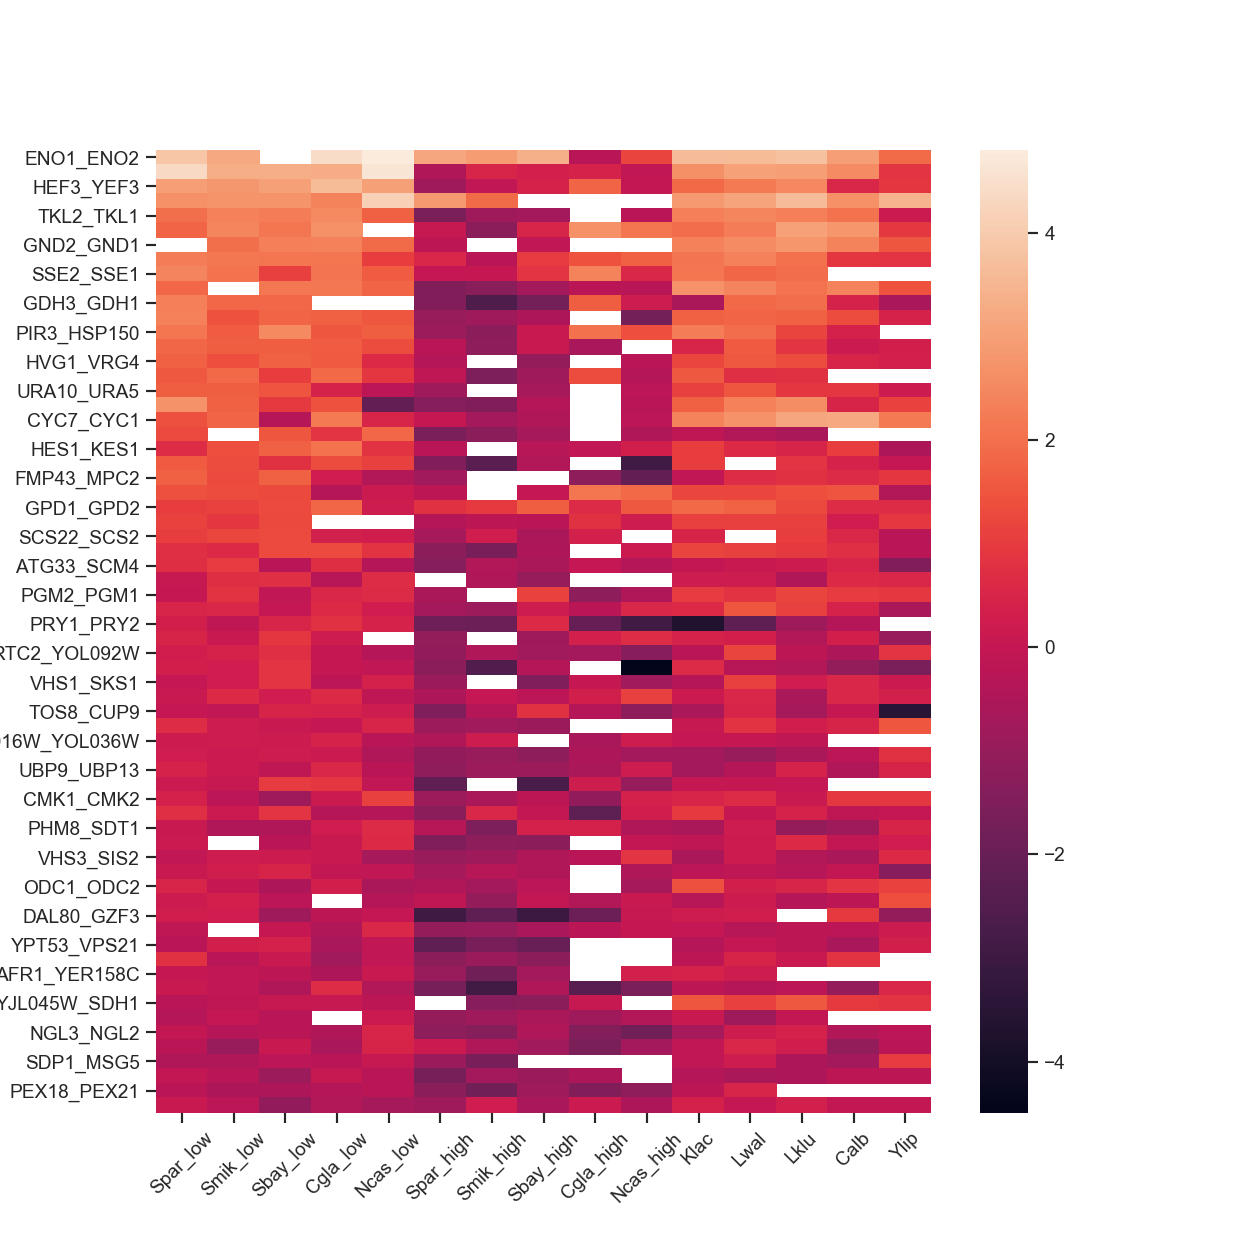

C:\Users\BMH_work\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[Text(0.5,0,'Spar_low'),
 Text(1.5,0,'Smik_low'),
 Text(2.5,0,'Sbay_low'),
 Text(3.5,0,'Cgla_low'),
 Text(4.5,0,'Ncas_low'),
 Text(5.5,0,'Spar_high'),
 Text(6.5,0,'Smik_high'),
 Text(7.5,0,'Sbay_high'),
 Text(8.5,0,'Cgla_high'),
 Text(9.5,0,'Ncas_high'),
 Text(10.5,0,'Klac'),
 Text(11.5,0,'Lwal'),
 Text(12.5,0,'Lklu'),
 Text(13.5,0,'Calb'),
 Text(14.5,0,'Ylip')]

In [184]:
flat_clust = sch.fcluster(row_cluster,1.0, criterion='distance')

fig_clust2, ax_clust2 = plt.subplots(figsize=(10,10))

#pick data from a given cluster
cluster_no = 2
expression_data_clust = expression_data_df_row_filter[flat_clust==cluster_no]

#sort by average of the low columns
cols_to_avg = ['Spar_low', 'Smik_low', 'Sbay_low', 'Cgla_low', 'Ncas_low']
expression_data_clust_subset =  expression_data_clust.loc[:,cols_to_avg]
expression_data_clust['low_median'] = expression_data_clust_subset.median(axis=1)
expression_data_clust_sorted = expression_data_clust.sort_values(by='low_median', ascending=False)
hm = sns.heatmap(expression_data_clust_sorted.drop(columns = 'low_median') , ax=ax_clust2)
hm.set_xticklabels(hm.get_xticklabels(), rotation = 45)

<IPython.core.display.Javascript object>


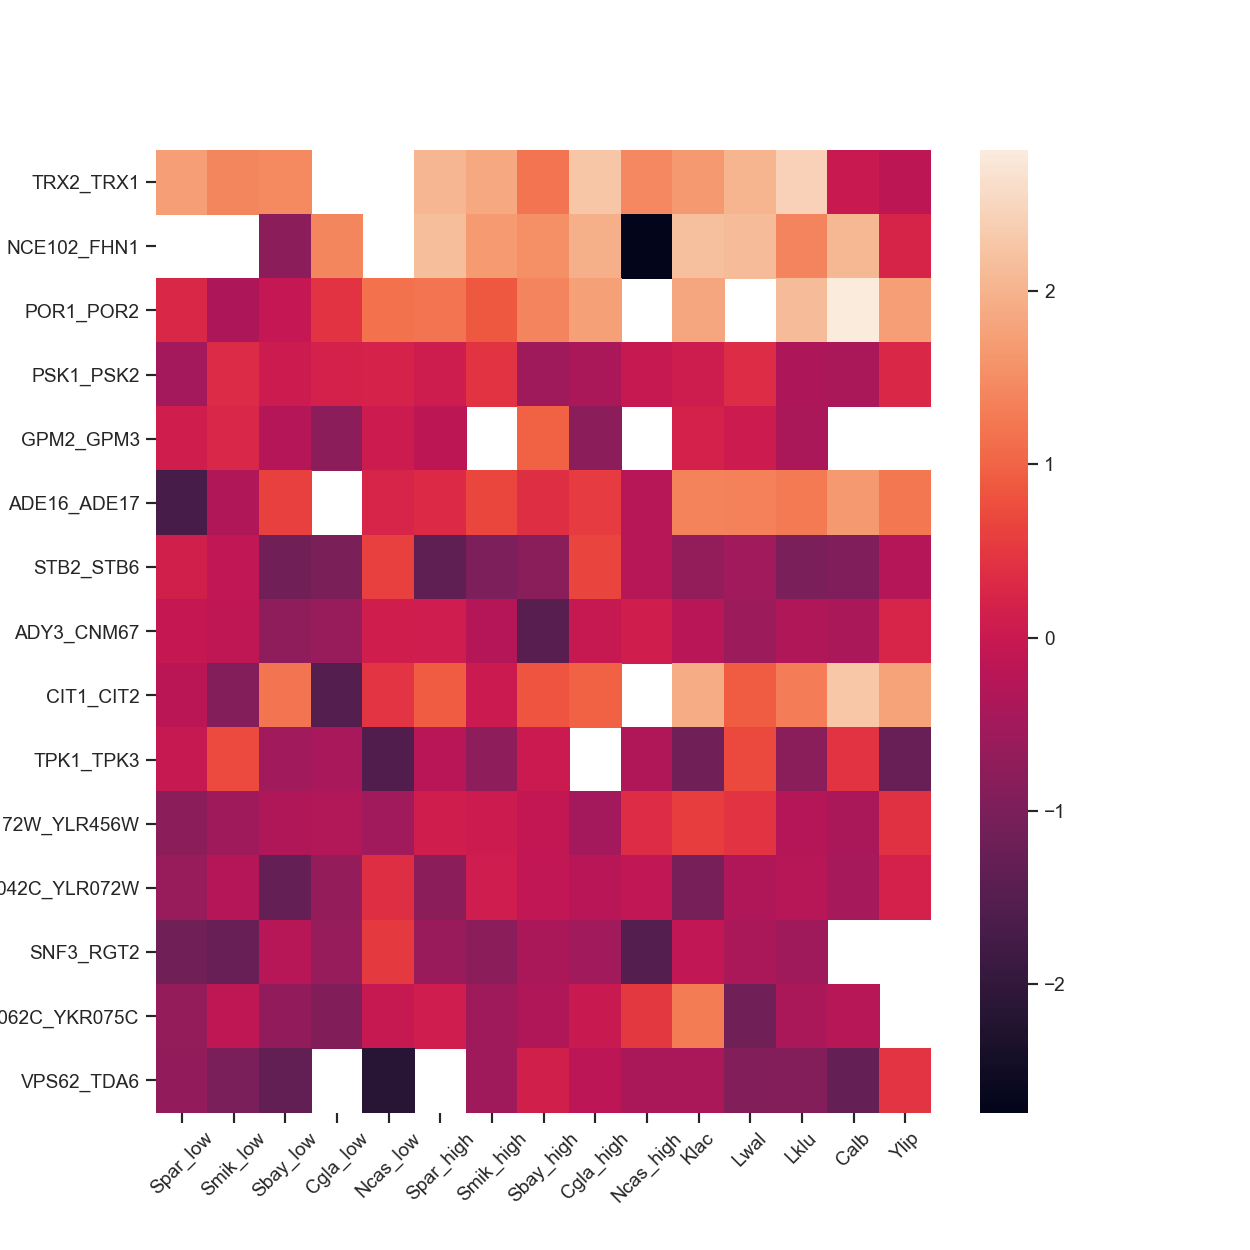

C:\Users\BMH_work\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[Text(0.5,0,'Spar_low'),
 Text(1.5,0,'Smik_low'),
 Text(2.5,0,'Sbay_low'),
 Text(3.5,0,'Cgla_low'),
 Text(4.5,0,'Ncas_low'),
 Text(5.5,0,'Spar_high'),
 Text(6.5,0,'Smik_high'),
 Text(7.5,0,'Sbay_high'),
 Text(8.5,0,'Cgla_high'),
 Text(9.5,0,'Ncas_high'),
 Text(10.5,0,'Klac'),
 Text(11.5,0,'Lwal'),
 Text(12.5,0,'Lklu'),
 Text(13.5,0,'Calb'),
 Text(14.5,0,'Ylip')]

In [198]:
flat_clust = sch.fcluster(row_cluster,1.0, criterion='distance')

fig_clust2, ax_clust2 = plt.subplots(figsize=(10,10))

#all data that is not in cluster 2
expression_data_clust = expression_data_df_row_filter[flat_clust != 2]

#sort by average of the low columns
cols_to_avg = ['Spar_low', 'Smik_low', 'Sbay_low', 'Cgla_low', 'Ncas_low']
expression_data_clust_subset =  expression_data_clust.loc[:,cols_to_avg]
expression_data_clust['low_median'] = expression_data_clust_subset.median(axis=1)
expression_data_clust_sorted = expression_data_clust.sort_values(by='low_median', ascending=False)
hm = sns.heatmap(expression_data_clust_sorted.drop(columns = 'low_median') , ax=ax_clust2)
hm.set_xticklabels(hm.get_xticklabels(), rotation = 45)

In [41]:
#Heirarchical cluster of genes with columns ordered as above to visualise ESR genes. 

#First filter out items with mostly NA values. 
kl_stress_nmpp1_data_filt = kl_stress_nmpp1_data_col_reorder.dropna(thresh=(len(kl_stress_nmpp1_data_col_reorder.columns)-1))

#Drop out PKA column for clustering
kl_stress_data = kl_stress_nmpp1_data_filt.drop('KL_PKA(AS)+1NMPP1', axis = 1)

kl_stress_data_nafill = kl_stress_data.fillna(0.0)
kl_stress_data_mat = kl_stress_data_nafill.as_matrix()

#fig3, ax_cm = plt.subplots()
#ax_cm = sns.clustermap(kl_stress_data_col_reorder_nafill,colcluster = False)
#ax_cm.ax_heatmap.tick_params(labelleft = 'off')

row_cluster = sch.linkage(kl_stress_data_mat, method='average')
row_ind_reorder = sch.leaves_list(row_cluster)

old_rows = kl_stress_nmpp1_data_filt.index.tolist()
new_rows = [old_rows[ind] for ind in row_ind_reorder]

kl_stress_nmpp1_data_filt_reorder = kl_stress_nmpp1_data_filt.reindex(new_rows)

fig3, ax3 = plt.subplots()
#ax3= sns.heatmap(kl_stress_nmpp1_data_filt_reorder)
# ax3 = plt.imshow(kl_stress_nmpp1_data_filt_reorder.as_matrix(), cmap='RdBu', vmin=z_min, vmax=z_max,
#            extent=[x.min(), x.max(), y.min(), y.max()],
#            interpolation='nearest', origin='lower')
ax3 = plt.imshow(-kl_stress_nmpp1_data_filt_reorder.as_matrix(), interpolation="nearest", aspect = 'auto', cmap = 'RdBu',vmin = -6, vmax = 6)
plt.axis('off')
plt.savefig('C:\Users\Ben\Google Drive\UCSF\ElSamad_Lab\Lab Meeting\\20161118\KL_genes.png')


0

# Phylogeny of gene induction
